0016E5_08430.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


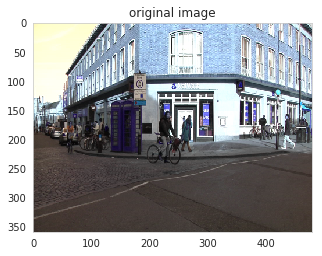

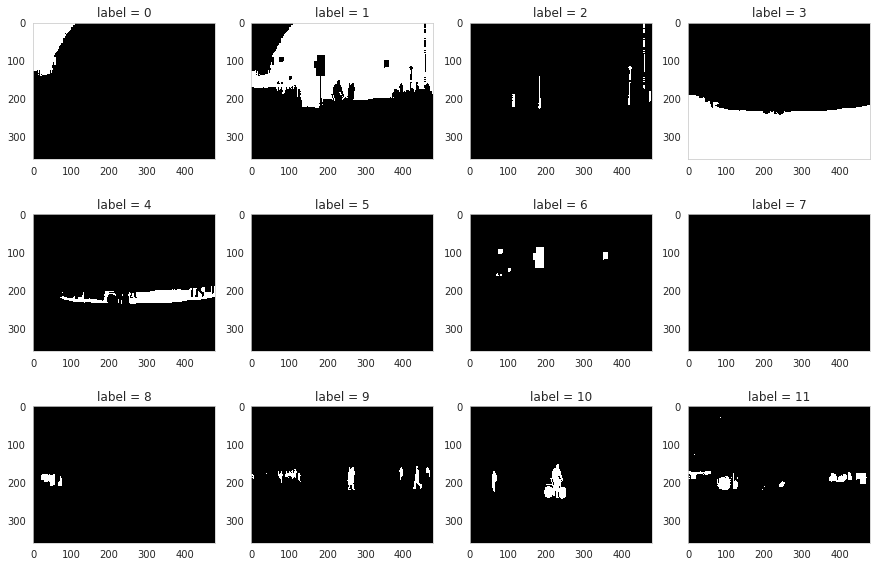

In [1]:
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

import cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))


plt.show()



In [2]:
plt.imread(dir_img + fnm).shape, plt.imread(dir_seg + fnm).shape

((360, 480, 3), (360, 480))

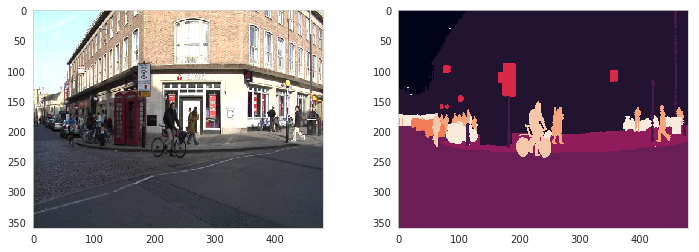

In [3]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(plt.imread(dir_img + fnm))
ax[1].imshow(plt.imread(dir_seg + fnm))

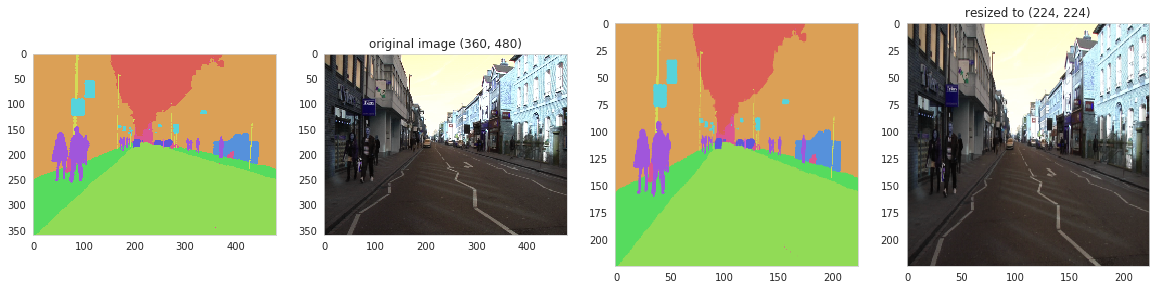

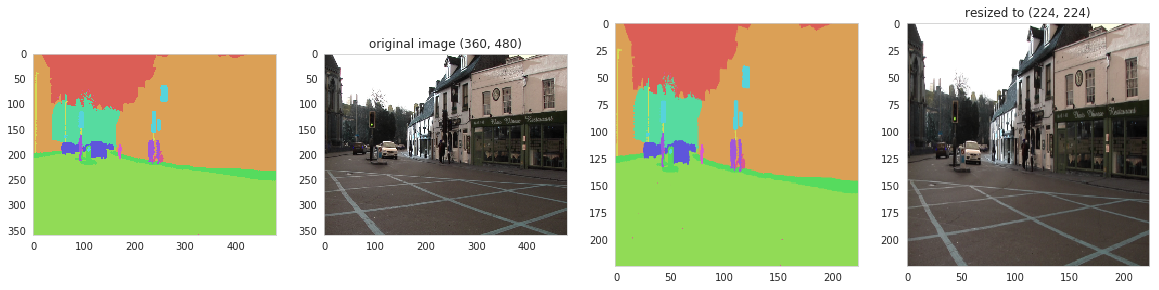

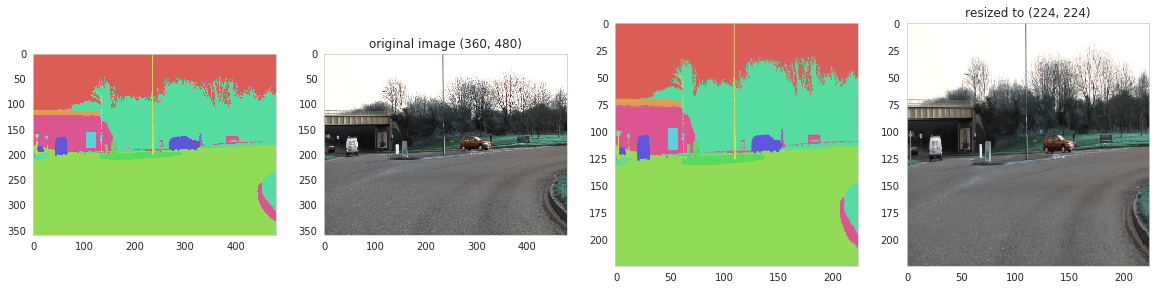

In [4]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [1]:
## Import usual libraries
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
from keras.utils import plot_model 

warnings.filterwarnings("ignore")

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "2" 
# set_session(tf.Session(config=config))   

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


python 3.6.3 |Anaconda, Inc.| (default, Nov 20 2017, 20:41:42) 
[GCC 7.2.0]
keras version 2.2.4
tensorflow version 1.12.0


Using TensorFlow backend.


In [15]:
# plot_model(model, to_file='fcn8.png') 

In [14]:
# model_ = Model(mobilenet.input, [mobilenet.output, 
#                                  mobilenet.get_layer('conv_pw_11_relu').output,
#                                  mobilenet.get_layer('conv_pw_5_relu').output])

In [6]:
from keras.applications.mobilenet import MobileNet

def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    n = 512
    o = Conv2D(n, (7,7), activation='relu', padding='same', name="conv6")(mobilenet.output)
    conv7 = Conv2D(n, (1,1), activation='relu', padding='same', name="conv7")(o)

    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose(nClasses, (4,4), strides=(4,4), use_bias=False )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = Conv2D( nClasses, (1,1),activation='relu', padding='same', name="pool4_11")(mobilenet.get_layer('conv_pw_11_relu').output)
    pool411_2 = Conv2DTranspose(nClasses, (2,2), strides=(2,2), use_bias=False )(pool411)

    pool311 = Conv2D(nClasses, (1,1), activation='relu' , padding='same', name="pool3_11")(mobilenet.get_layer('conv_pw_5_relu').output)

    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
    o = (Activation('softmax'))(o)

    model = Model(mobilenet.input, o)
    return model

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()



In [7]:
# def build_discriminator():
import keras

inp = Input(shape=(128,128,3))
x = inp
x = Conv2D(32, kernel_size=5, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)

x = Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D(2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inp,x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 64)        256       
__________

In [ ]:
def buld_desc():
    inp = Input(shape=(128,128,3))
    x = inp
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inp,x)
    
    return model

In [ ]:
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


In [ ]:
desc = build_desc()
optimizer = Adam(0.0002, 0.5)

desc.compile(loss      = 'binary_crossentropy',
             optimizer = optimizer,
             metrics   = ['accuracy'])

fcn_model = FCN8(nClasses     = n_classes,  
                 input_height = 224, 
                 input_width  = 224)


fcn_inp = Input(shape=(128,128,3))
seg_map = fcn_model(fcn_inp)

# real = Input(shape=(128,128,3))
# The discriminator takes generated images as input and determines validity
desc.trainable = False
valid = desc(seg_map)

combine = Model(fcn_inp, [seg_map, valid])

combine.compile(optimizer='adam',
                loss={'gen':'categorical_crossentropy', 'desc':'binary_crossentropy'},
                loss_weights={'gen':1, 'des':0.2})

In [ ]:
model.compile(optimizer='rmsprop',
              loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2})

# And trained it via:
model.fit({'main_input': headline_data, 'aux_input': additional_data},
          {'main_output': labels, 'aux_output': labels},
          epochs=50, batch_size=32)

In [ ]:
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


In [6]:

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [7]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels



input_width , input_height = 224, 224
images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


In [8]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [ ]:
# from keras import optimizers


# sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])

# hist1 = model.fit(X_train,y_train,
#                   validation_data=(X_test,y_test),
#                   batch_size=32,epochs=200,verbose=2)


In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [10]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint#, LearningRateScheduler


# LOG_FILE_PATH = 'fcn-chkt/fcn8-baseline.hdf5'#-{epoch:02d}-{mean_iou:.4f}.hdf5'
# checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
#                              verbose=1, 
#                              save_best_only=True)

# early_stop = EarlyStopping(patience=5,
# #                            monitor='val_loss', 
# #                            min_delta=0.001, 
# #                            mode='min', 
#                            verbose=1)

# reduce_lr = ReduceLROnPlateau(factor=0.2, 
# #                               monitor='val_loss', 
#                               patience=2, 
#                               min_lr=1e-8)
                              
import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.optimizers import Adam


with tf.device('/cpu:0'):
#     model = build_model(inputs)
    model = FCN8(nClasses = n_classes, input_height = 224, input_width  = 224)
#     wt_dir1 = '../weights/improved-baseline/attention_more_data_wts_1.6000001e-06_0.068.npy'
#     w_load = np.load(wt_dir1)
#     load= True
#     if load:
#         model.set_weights(w_load)
#     #     model.set_weights(wss)
#         print("loaded weights successfully")
    print("built model successfully")
    
    
optimizer = Adam(lr=0.5e-2, beta_1=0.9, beta_2=0.999)

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss = 'categorical_crossentropy',
                       optimizer=optimizer,
                       metrics=[mean_iou])
#               metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])




built model successfully


In [11]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint#, LearningRateScheduler


LOG_FILE_PATH = 'fcn-chkt/fcn8-baseline.hdf5'#-{epoch:02d}-{mean_iou:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
                             verbose=1, 
                             save_best_only=True)

early_stop = EarlyStopping(patience=5,
#                            monitor='val_loss', 
#                            min_delta=0.001, 
#                            mode='min', 
                           verbose=1)

reduce_lr = ReduceLROnPlateau(factor=0.2, 
#                               monitor='val_loss', 
                              patience=2, 
                              min_lr=1e-7) 

call_backs = [early_stop, reduce_lr, checkpoint]



In [15]:
X.shape, Y.shape, X_train.shape, y_train.shape

((367, 224, 224, 3),
 (367, 224, 224, 12),
 (311, 224, 224, 3),
 (311, 224, 224, 12))

In [12]:
EPOCHS = 100
print("let's start parallel model for 100 epochs")
parallel_model.fit( x                = X_train, 
                    y                = y_train, 
                    batch_size       = 50, 
                    epochs           = EPOCHS, 
                    verbose          = 1, 
                    callbacks        = call_backs, 
                    validation_data  = (X_test,y_test), 
                    shuffle          = True, 
                    initial_epoch    = 0)

let's start parallel model for 100 epochs
Train on 311 samples, validate on 56 samples
Epoch 1/100
311/311 [==============================] - 31s 101ms/step - loss: 2.4087 - mean_iou: 0.3853 - val_loss: 2.1256 - val_mean_iou: 0.4655

Epoch 00001: val_loss improved from inf to 2.12561, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 2/100
311/311 [==============================] - 8s 26ms/step - loss: 1.5780 - mean_iou: 0.4750 - val_loss: 1.8041 - val_mean_iou: 0.5014

Epoch 00002: val_loss improved from 2.12561 to 1.80413, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 3/100
311/311 [==============================] - 8s 26ms/step - loss: 1.1745 - mean_iou: 0.5212 - val_loss: 2.1006 - val_mean_iou: 0.5409

Epoch 00003: val_loss did not improve from 1.80413
Epoch 4/100
150/311 [=============>................] - ETA: 3s - loss: 1.0095 - mean_iou: 0.5500

KeyboardInterrupt: 

In [14]:
EPOCHS = 100
print("let's start parallel model for 100 epochs")
parallel_model.fit( x                = X_train, 
                    y                = y_train, 
                    batch_size       = 100, 
                    epochs           = EPOCHS, 
                    verbose          = 1, 
                    callbacks        = call_backs, 
                    validation_data  = (X_test,y_test), 
                    shuffle          = True, 
                    initial_epoch    = 0)

let's start parallel model for 100 epochs
Train on 311 samples, validate on 56 samples
Epoch 1/100
311/311 [==============================] - 10s 33ms/step - loss: 0.9645 - mean_iou: 0.5722 - val_loss: 1.5317 - val_mean_iou: 0.5866

Epoch 00001: val_loss improved from 1.80413 to 1.53174, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 2/100
311/311 [==============================] - 8s 25ms/step - loss: 0.9374 - mean_iou: 0.5949 - val_loss: 1.4245 - val_mean_iou: 0.6051

Epoch 00002: val_loss improved from 1.53174 to 1.42452, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 3/100
311/311 [==============================] - 8s 25ms/step - loss: 0.9036 - mean_iou: 0.6109 - val_loss: 1.5865 - val_mean_iou: 0.6185

Epoch 00003: val_loss did not improve from 1.42452
Epoch 4/100
311/311 [==============================] - 8s 25ms/step - loss: 0.8883 - mean_iou: 0.6214 - val_loss: 1.7586 - val_mean_iou: 0.6270

Epoch 00004: val_loss did not improve from 1.42452
Epoch 5/100
311/311 [=========

311/311 [==============================] - 8s 25ms/step - loss: 0.7555 - mean_iou: 0.7042 - val_loss: 0.7494 - val_mean_iou: 0.7046

Epoch 00036: val_loss did not improve from 0.74671
Epoch 37/100
311/311 [==============================] - 8s 25ms/step - loss: 0.7562 - mean_iou: 0.7050 - val_loss: 0.7461 - val_mean_iou: 0.7054

Epoch 00037: val_loss improved from 0.74671 to 0.74615, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 38/100
311/311 [==============================] - 8s 25ms/step - loss: 0.7524 - mean_iou: 0.7057 - val_loss: 0.7470 - val_mean_iou: 0.7061

Epoch 00038: val_loss did not improve from 0.74615
Epoch 39/100
311/311 [==============================] - 8s 24ms/step - loss: 0.7565 - mean_iou: 0.7064 - val_loss: 0.7435 - val_mean_iou: 0.7068

Epoch 00039: val_loss improved from 0.74615 to 0.74349, saving model to fcn-chkt/fcn8-baseline.hdf5
Epoch 40/100
311/311 [==============================] - 8s 25ms/step - loss: 0.7566 - mean_iou: 0.7071 - val_loss: 0.7420 - val

In [ ]:
# hist1 = model.fit(X_train,y_train,
#                   validation_data=(X_test,y_test),
#                   batch_size=32,epochs=200,verbose=2)


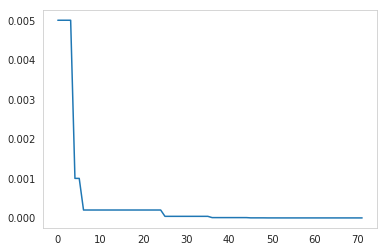

In [18]:
plt.plot(parallel_model.history.history['lr'])

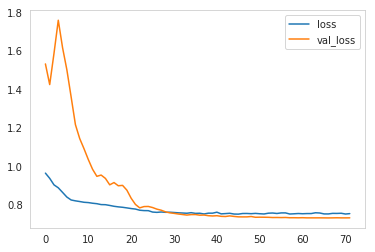

In [15]:
for key in ['loss', 'val_loss']:
    plt.plot(parallel_model.history.history[key],label=key)
plt.legend()
plt.show()


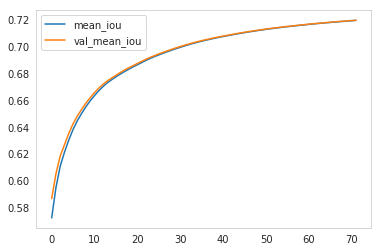

In [16]:
for key in ['mean_iou', 'val_mean_iou']:
    plt.plot(parallel_model.history.history[key],label=key)
plt.legend()
plt.show()


In [19]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)


(56, 224, 224) (56, 224, 224)


In [20]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)


class 00: #TP=403062, #FP= 60711, #FN=22117, IoU=0.830
class 01: #TP=621962, #FP=313267, #FN=51579, IoU=0.630
class 02: #TP=     0, #FP=    16, #FN=31552, IoU=0.000
class 03: #TP=912828, #FP= 74390, #FN=37051, IoU=0.891
class 04: #TP= 38999, #FP= 34367, #FN=79058, IoU=0.256
class 05: #TP=109742, #FP= 42367, #FN=151900, IoU=0.361
class 06: #TP=     0, #FP=    43, #FN=32959, IoU=0.000
class 07: #TP=     0, #FP=     9, #FN=33727, IoU=0.000
class 08: #TP=112282, #FP= 78245, #FN=42613, IoU=0.482
class 09: #TP=     0, #FP=    27, #FN=15787, IoU=0.000
class 10: #TP=     0, #FP=    20, #FN=11584, IoU=0.000
class 11: #TP=  6988, #FP=   531, #FN=94066, IoU=0.069
_________________
Mean IoU: 0.293


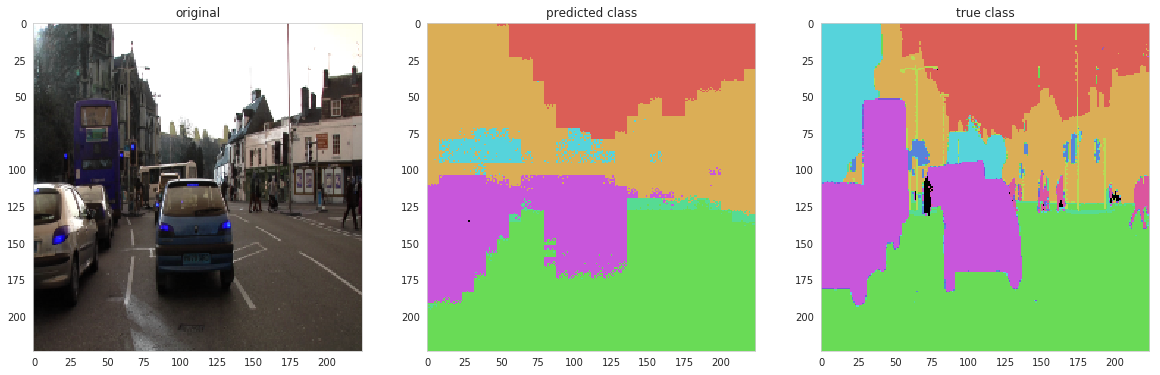

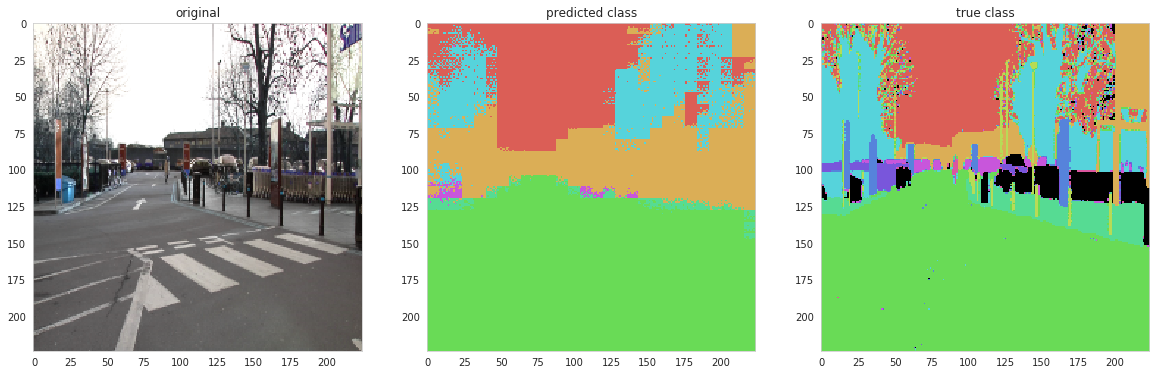

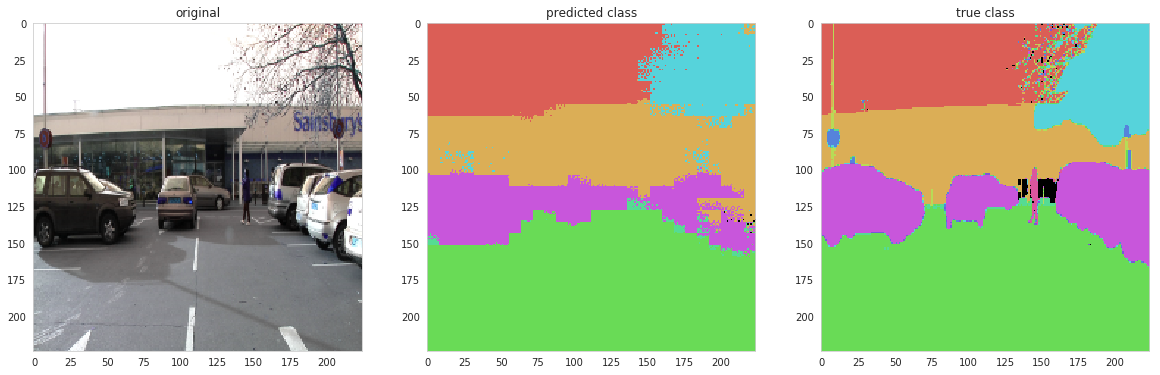

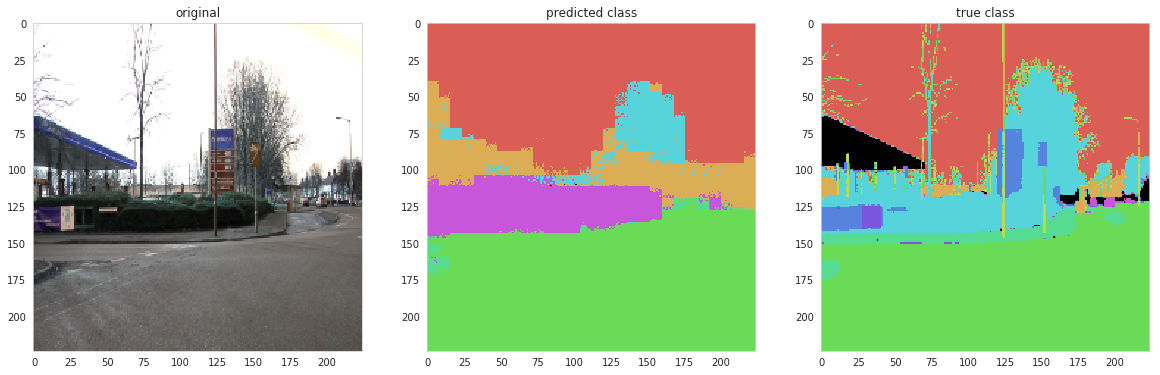

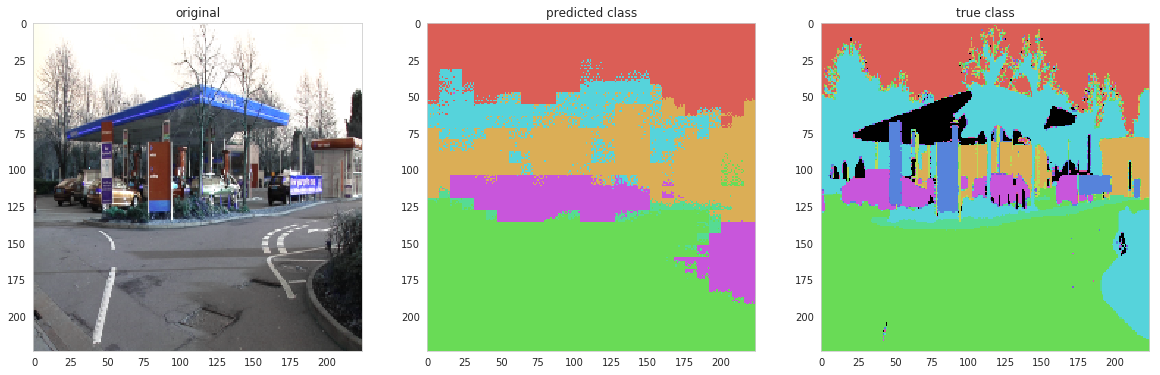

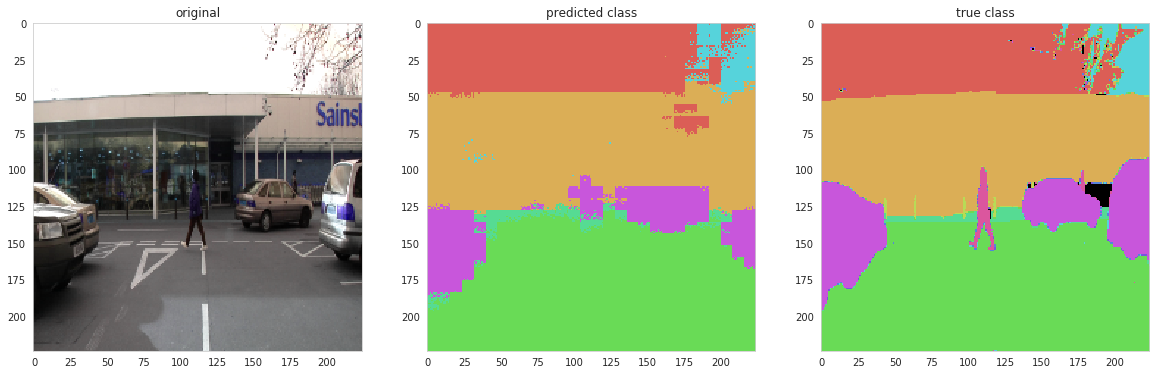

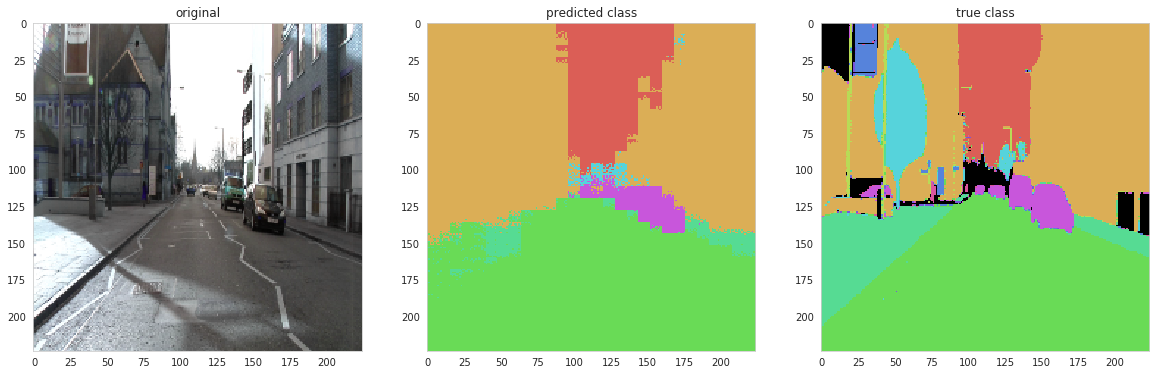

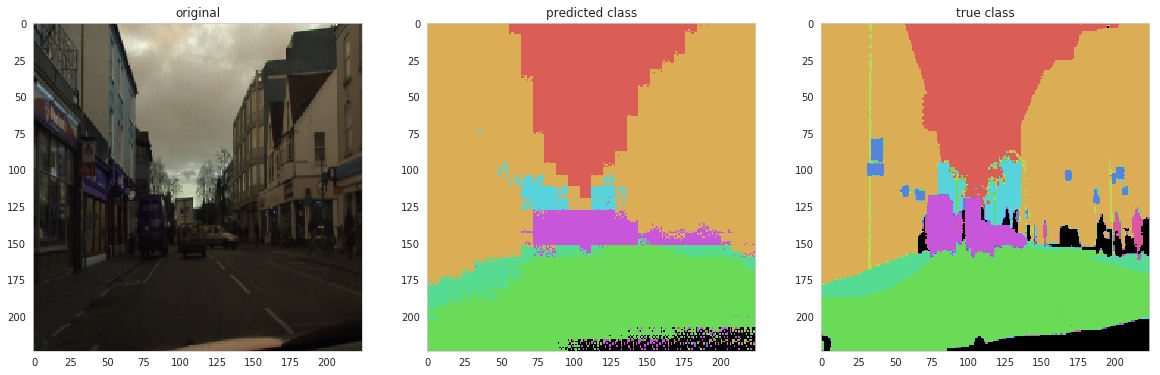

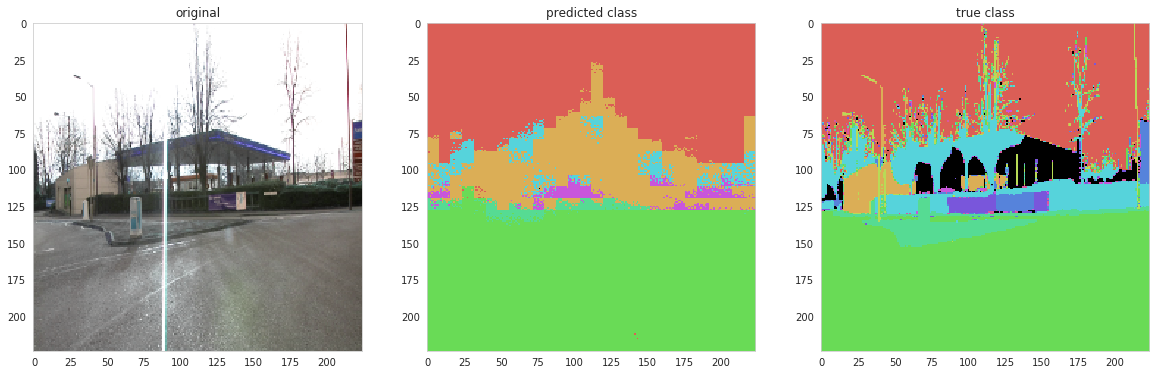

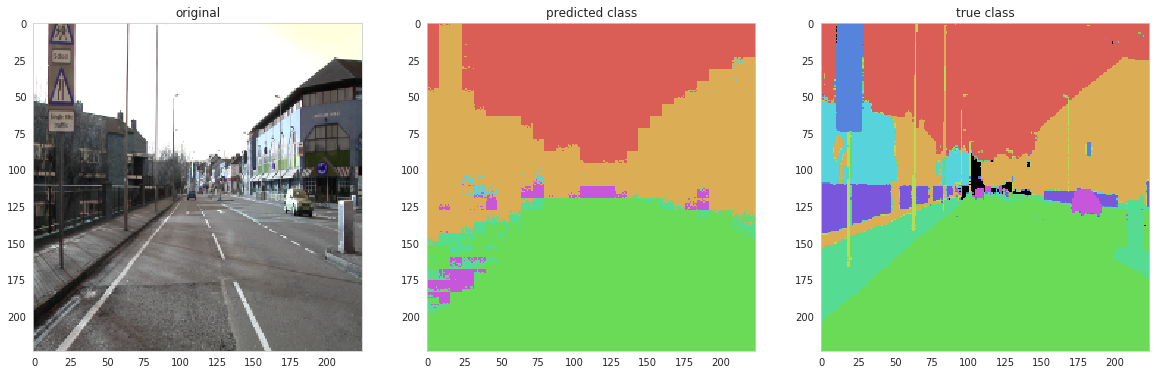

In [22]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,20))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()